In [493]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from sklearn import neighbors
from sklearn import tree
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier

***Лабораторная 1***

In [494]:
df = pd.read_csv("credit_card.csv")

Data set: http://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients
Info: содержит данные о пользователях кредитных карт в Тайване

Task: binary classification, нужно предсказать платежеспособность клиентов (label 1 - заплатил, label 0 - не заплатил)

Atribute Information:
* LIMIT_BAL - сумма кредита (dollars)
* SEX - пол (1 = male, 2 = female)
* EDUCATION - образование (1 = graduate school; 2 = university; 3 = high school; 4 = others)
* MARRIAGE - (1 = married; 2 = single; 3 = others)
* AGE - возраст
* PAY_[ 0,1,2,3,4,5,6 ] (DELAY)  - оплата в 7 предыдущих месяцах
    * -1 = оплатил вовремя
    * 1 = задолжал на 1 месяц
    * ...
    * 9 = задолжал на 9 месяцев и больше
* BILL_AMT[ 0,1,2,3,4,5,6 ] (STATE) - размер счета в каждом месяце
* PAY_AMT[ 0,1,2,3,4,5,6 ] (PAY)  - размер взноса в каждом месяце
* [default payment next month] - заплатит в следующем месяце или нет?

In [495]:
df.shape

(30000, 25)

Данные имеют 30k наблюдений и 24 признака

In [496]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


Удалим колонку с индексом и переменуем признаки для более удобной работы с ними

In [497]:
df = df.drop(columns=['ID'])
df = df.rename(index=str, columns={"BILL_AMT" + str(i) : "STATE" + str(i)  for i in range(7)})
df = df.rename(index=str, columns={"PAY_AMT" + str(i) : "PAY" + str(i)  for i in range(7)})
df = df.rename(index=str, columns={"PAY_" + str(i) : "DELAY" + str(i)  for i in range(7)})
df = df.rename(index=str, columns={"default payment next month": "label"})

In [498]:
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,DELAY0,DELAY2,DELAY3,DELAY4,DELAY5,...,STATE4,STATE5,STATE6,PAY1,PAY2,PAY3,PAY4,PAY5,PAY6,label
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


Преобразования прошли успешно, посмотрим на базовые статистики признаков:

In [499]:
df.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,DELAY0,DELAY2,DELAY3,DELAY4,DELAY5,...,STATE4,STATE5,STATE6,PAY1,PAY2,PAY3,PAY4,PAY5,PAY6,label
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


Самое интересное, что можно подчерпнуть из статистики, что среднее количество нулевых классов - 0.22. Это значит, что классы не сбалансированы, держим это в уме.
Посмотрим корреляцию признаков: 

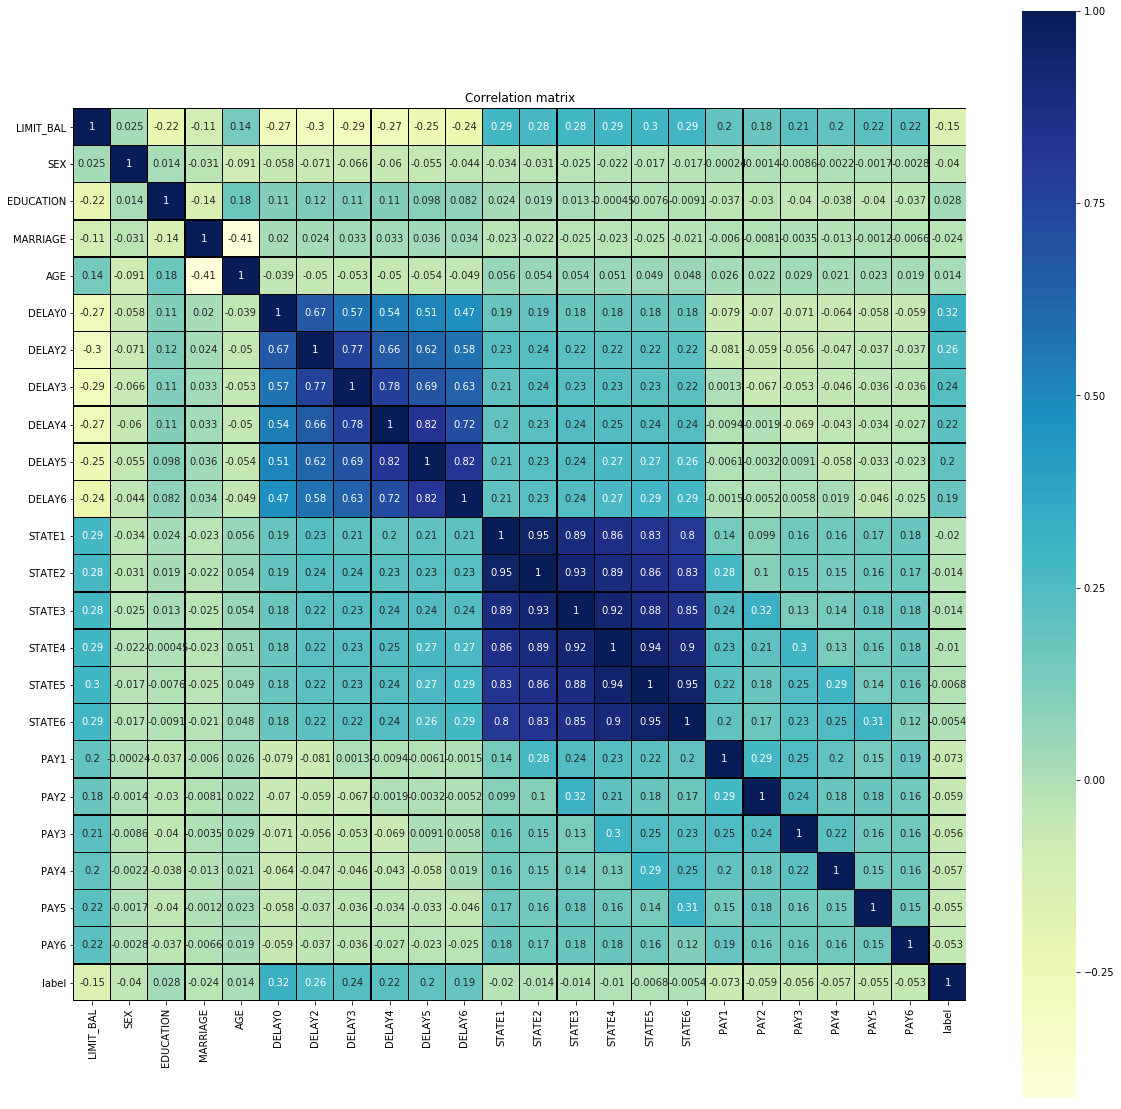

In [500]:
f, ax = plt.subplots(figsize=(20,20))
plt.title('Correlation matrix')
sns.heatmap(df.corr(), linewidths=0.25, vmax=1.0, square=True,
           cmap="YlGnBu", linecolor='black', annot=True)

Делаем следующие выводы:
* Задержки в выплотах(DELAY) в каждем месяце очень сильно зависят друг от друга
* Баланс счета (STATE) так же зависит друг от друга
* Ответ - коррелирует с DELAY, больше остальных признаков. 

Продолжим предобработку данных:
Признаки SEX, EDUCATION, MARRIAGE - категориальные, сделаем их бинаризацию

In [501]:
def do_one_hot_encoding(col, data):
    data = pd.concat([pd.get_dummies(data[col], prefix=col), data],axis=1)
    data.drop([col],axis=1, inplace=True)
    return data

df = do_one_hot_encoding('SEX', df)
df = do_one_hot_encoding('EDUCATION', df)
df = do_one_hot_encoding('MARRIAGE', df)

In [502]:
df.columns

Index(['MARRIAGE_0', 'MARRIAGE_1', 'MARRIAGE_2', 'MARRIAGE_3', 'EDUCATION_0',
       'EDUCATION_1', 'EDUCATION_2', 'EDUCATION_3', 'EDUCATION_4',
       'EDUCATION_5', 'EDUCATION_6', 'SEX_1', 'SEX_2', 'LIMIT_BAL', 'AGE',
       'DELAY0', 'DELAY2', 'DELAY3', 'DELAY4', 'DELAY5', 'DELAY6', 'STATE1',
       'STATE2', 'STATE3', 'STATE4', 'STATE5', 'STATE6', 'PAY1', 'PAY2',
       'PAY3', 'PAY4', 'PAY5', 'PAY6', 'label'],
      dtype='object')

Все на своих местах.

Из корреляционного анализа мы поняли, что признаки - зависимы. Что бы убрать эту зависимость и уменьшить пространство признаков - воспользуемся PCA.

Что бы подобрать оптимальное количество компонент - воспользуемся способом описанным здесь:
https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html

Нам нужно подсчитатать кумулятивную сумму вариации по компонентам.

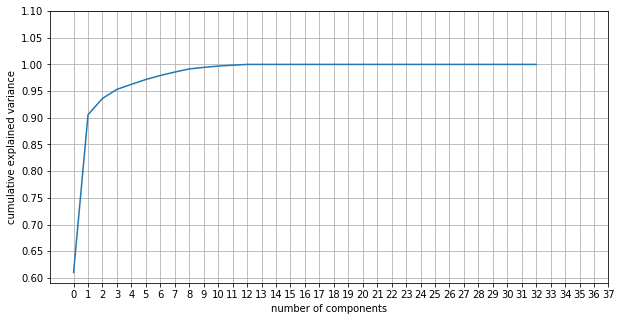

In [503]:
pca = PCA().fit(df.drop(['label'], axis=1))
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(111)
ax.plot(np.cumsum(pca.explained_variance_ratio_))
ax.set_xticks(np.arange(0,38,1))
ax.set_yticks(np.arange(0.6,1.1,0.05))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.grid(True)


Видно, что при n_components = 10 мы достигаем практически 100% вариации - остановимся на этом и сделаем трансформацию данных:

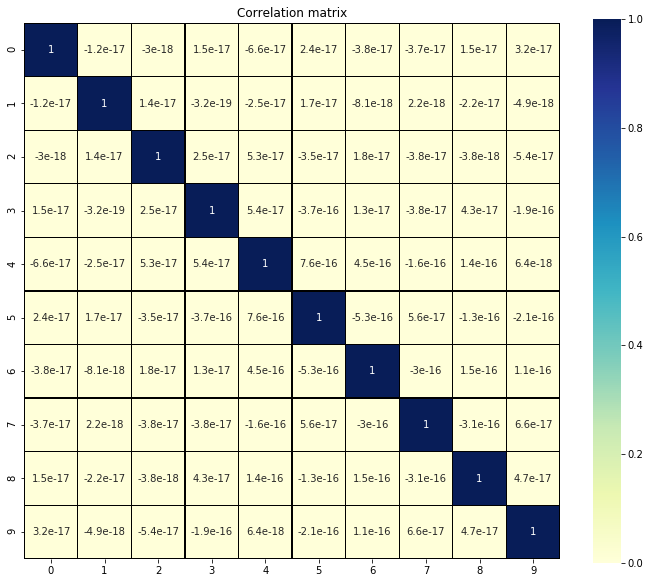

In [521]:
pca = PCA(n_components = 10, random_state=123)
data = pca.fit_transform(df.drop(['label'], axis=1))
f, ax = plt.subplots(figsize=(12,10))
plt.title('Correlation matrix')
sns.heatmap(np.corrcoef(data.T), linewidths=0.25, vmax=1.0, square=True,
           cmap="YlGnBu", linecolor='black', annot=True)

In [505]:
print(df.shape)
print(data.shape)

(30000, 34)
(30000, 10)


Избавились от зависимостей между признаками, теперь разделим дата сет на тренинговый и тестовый. В пропорции - 0.7 и 0.3.

In [506]:
X_train, X_test, y_train, y_test = train_test_split(data, np.array(df['label']), test_size=0.3, random_state=42)

Применим линейную модель для классификации - логистическую регрессию.

In [507]:
%%time
log_reg = LogisticRegression(random_state=0, solver='lbfgs', max_iter=1000)
log_reg.fit(X_train, y_train)
print("train accuracy =", log_reg.score(X_train, y_train))
print("test accuracy  =", log_reg.score(X_test, y_test))

train accuracy = 0.5055714285714286
test accuracy  = 0.5097777777777778
Wall time: 75 ms


Получили плохие очень результаты для бинарной классификации. Одной из причин может быть - не нормализированные данные.
Нормализуем их с помощью Z-Score нормализации.

In [508]:
zscore = StandardScaler()
data_zscore = zscore.fit_transform(df.drop('label', axis=1))

Проделаем тот же анализ с PCA:

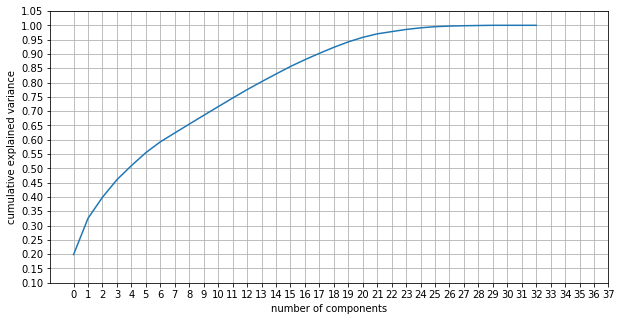

In [509]:
pca = PCA().fit(data_zscore)
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(111)
ax.plot(np.cumsum(pca.explained_variance_ratio_))
ax.set_xticks(np.arange(0,38,1))
ax.set_yticks(np.arange(0.1,1.1,0.05))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.grid(True)

Теперь значищих компонент стало намного больше. Выберем значение 19 - находящееся на уровне 95%

In [510]:
pca = PCA(n_components = 19, random_state=123)
data = pca.fit_transform(data_zscore)

In [511]:
X_train, X_test, y_train, y_test = train_test_split(data, np.array(df['label']), test_size=0.3, random_state=42)

In [512]:
%%time
log_reg = LogisticRegression(random_state=0, solver='lbfgs', max_iter=1000)
log_reg.fit(X_train, y_train)
print("train accuracy =", log_reg.score(X_train, y_train))
print("test accuracy  =", log_reg.score(X_test, y_test))

# get_score(log_reg, X_test, y_test)

train accuracy = 0.8042380952380952
test accuracy  = 0.803
Wall time: 54 ms


В этот раз логистическая регрессия показала результаты намного лучше - 80.3% точности. Что говорит о том, что нормализация действительно помогла.

Посмотрим какие результаты будут с другими классификаторами:
Возьмем kNN:

In [513]:
%%time
knn=neighbors.KNeighborsClassifier(n_neighbors=16)
knn.fit(X_train, y_train)
# get_score(knn, X_test, y_test)

print("train accuracy =", knn.score(X_train, y_train))
print("test accuracy  =", knn.score(X_test, y_test))

train accuracy = 0.8189047619047619
test accuracy  = 0.8046666666666666
Wall time: 11 s


Точность получается примерно такая-же, однако knn сработал намного медленее.

Решающее дерево:

In [514]:
%%time
dtree = tree.DecisionTreeClassifier()
dtree.fit(X_train, y_train)

print("train accuracy =", dtree.score(X_train, y_train))
print("test accuracy  =", dtree.score(X_test, y_test))

train accuracy = 0.9995238095238095
test accuracy  = 0.7076666666666667
Wall time: 780 ms


Решающее дерево переобучилось (99% точности на тренинговых данных и 71% на тестовых) - урежем его высоту:

In [515]:
%%time
dtree = tree.DecisionTreeClassifier(max_depth=3)
dtree.fit(X_train, y_train)

print("train accuracy =", dtree.score(X_train, y_train))
print("test accuracy  =", dtree.score(X_test, y_test))

train accuracy = 0.8039047619047619
test accuracy  = 0.7973333333333333
Wall time: 151 ms


Так намного лучше, теперь оно предсказывает с тако-же точностью, что и логистическая регрессия.

Ради эксперемента посмотрим, какие результаты мы получим, если не будем уменьшать пространство признаков с помощью PCA: 

In [516]:
X_train, X_test, y_train, y_test = train_test_split(data_zscore, np.array(df['label']), test_size=0.3, random_state=42)

In [517]:
%%time
log_reg = LogisticRegression(random_state=0, solver='lbfgs', max_iter=1000)
log_reg.fit(X_train, y_train)
print("train accuracy =", log_reg.score(X_train, y_train))
print("test accuracy  =", log_reg.score(X_test, y_test))

train accuracy = 0.8116666666666666
test accuracy  = 0.8095555555555556
Wall time: 107 ms


In [518]:
%%time
knn=neighbors.KNeighborsClassifier(n_neighbors=16)
knn.fit(X_train, y_train)
# get_score(knn, X_test, y_test)

print("train accuracy =", knn.score(X_train, y_train))
print("test accuracy  =", knn.score(X_test, y_test))

train accuracy = 0.8212857142857143
test accuracy  = 0.8076666666666666
Wall time: 1min 10s


In [519]:
%%time
dtree = tree.DecisionTreeClassifier(max_depth=3)
dtree.fit(X_train, y_train)

print("train accuracy =", dtree.score(X_train, y_train))
print("test accuracy  =", dtree.score(X_test, y_test))

train accuracy = 0.8209047619047619
test accuracy  = 0.8205555555555556
Wall time: 133 ms


С одной стороны мы смогли натренировать решающее дерево, которое теперь дает точность предсказания - 82%, с другой стороны время выполнения алгоритмов увеличилось. Например, для kNN c 10s до 1m.

Т.е. применение PCA может сделать как лучше, так и хуже. Зависит от ситуации.

***Лабораторная 2***

Прменим нейронные сети для классификации

In [ ]:
%%time
